[1. 1.]
[0.0039216 1.9960784]
[1.9960784 0.0039216]


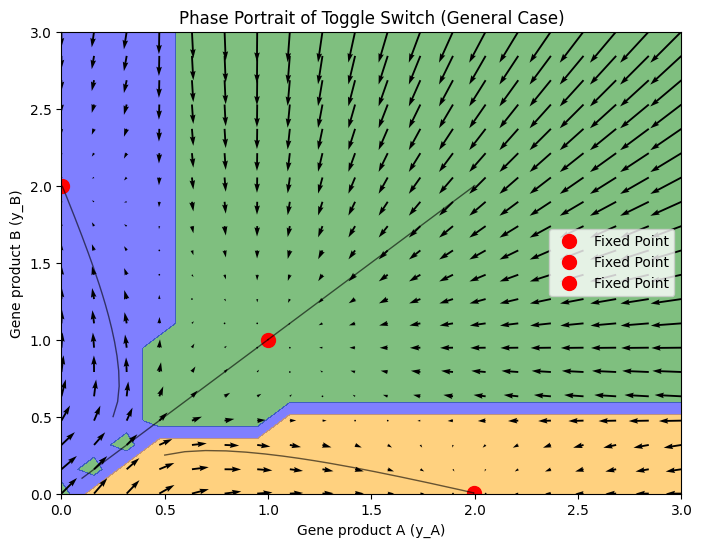

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve

# Define the system of differential equations (toggle switch) with positive feedback and repression
"""
    y_A: Concentration of gene product A (dynamic variable)
    
    y_B: Concentration of gene product B (dynamic variable)

    a_A: Maximum rate of production of gene product A due to self-regulation
            This represents how much gene A positively regulates itself.

    b_A: Maximum repression effect of gene product B on gene A
            Represents the strength of repression of gene A by gene B.

    a_B: Maximum rate of production of gene product B due to self-regulation
            This represents how much gene B positively regulates itself.

    b_B: Maximum repression effect of gene product A on gene B
            Represents the strength of repression of gene B by gene A.

    K_A: Repression constant for gene A by gene B
            This is the threshold value for the repression of gene A by gene B.

    K_B: Repression constant for gene B by gene A
            This is the threshold value for the repression of gene B by gene A.

    K_A_plus: Positive feedback constant for gene A
            Threshold value for the positive self-regulation of gene A. Lower values mean stronger self-activation.

    K_B_plus: Positive feedback constant for gene B
        Threshold value for the positive self-regulation of gene B. Lower values mean stronger self-activation.

    n: Hill coefficient 
        Represents the cooperativity in the positive feedback of both genes. Larger values imply switch-like behavior.

    m: Hill coefficient for repression
        Represents the cooperativity in the repression of both genes. Larger values imply more switch-like behavior.

    d_A: Degradation rate of gene product A
        Represents how quickly gene product A is degraded or diluted.

    d_B: Degradation rate of gene product B
        Represents how quickly gene product B is degraded or diluted

"""

def toggle_switch(y, t, a_A, b_A, a_B, b_B, K_A, K_B, K_A_plus, K_B_plus, m, n, d_A, d_B):
    y_A, y_B = y
    
    # Positive feedback Hill kinetics for self-regulation
    positive_feedback_A = (y_A**n) / (K_A_plus**n + y_A**n)
    positive_feedback_B = (y_B**n) / (K_B_plus**n + y_B**n)
    
    # Repression functions with Hill kinetics
    repression_A = a_A * positive_feedback_A +( b_A * (K_B**m) / (K_B**m + y_B**m))
    repression_B = a_B * positive_feedback_B +( b_B * (K_A**m) / (K_A**m + y_A**m))
    
    # ODEs for gene products A and B
    dydt_A = repression_A - d_A * y_A
    dydt_B = repression_B - d_B * y_B
    
    return [dydt_A, dydt_B]

# Find fixed points by solving dydt_A = 0 and dydt_B = 0
def find_fixed_points_toggle_switch(a_A, b_A, a_B, b_B, K_A, K_B, K_A_plus, K_B_plus, m, n, d_A, d_B):
    def equations(y):
        return toggle_switch(y, 0, a_A, b_A, a_B, b_B, K_A, K_B, K_A_plus, K_B_plus, m, n, d_A, d_B)
    
    initial_guesses = [ [1, 1], [0, 2], [2, 0]]
    fixed_points = [fsolve(equations, guess) for guess in initial_guesses]
    
    return fixed_points

# Parameters
a_A = 1   # maximum expression rate of A from positive feedback
a_B = 1  # maximum expression rate of B from positive feedback
b_A = 1   # maximum repression rate of A from B
b_B = 1    # maximum repression rate of B from A
K_A = 0.5     # repression threshold of A
K_B = 0.5    # repression threshold of B
K_A_plus = 0.5 # positive feedback threshold of A
K_B_plus = 0.5 # positive feedback threshold of B
m = 4        # Hill coefficient for repression
n = 4        # Hill coefficient for positive feedback
d_A = 1    # degradation rate of A
d_B = 1    # degradation rate of B

'''
    Also try these:
    a_A = 1   # maximum expression rate of A from positive feedback
    a_B = 1  # maximum expression rate of B from positive feedback
    b_A = 1   # maximum repression rate of A from B
    b_B = 1    # maximum repression rate of B from A
    K_A = 0.5     # repression threshold of A
    K_B = 0.5    # repression threshold of B
    K_A_plus = 1 # positive feedback threshold of A
    K_B_plus = 1 # positive feedback threshold of B
    m = 4        # Hill coefficient for repression
    n = 4        # Hill coefficient for positive feedback
    d_A = 1    # degradation rate of A
    d_B = 1    # degradation rate of B

'''

# Grid for phase space
y_A_vals = np.linspace(0, 3, 20)
y_B_vals = np.linspace(0, 3, 20)
Y_A, Y_B = np.meshgrid(y_A_vals, y_B_vals)

# Set up parameters for simulation
time = np.linspace(0, 100, 1000)  # Simulate over a long period to reach steady state
colors = ['green', 'blue', 'orange']  # Colors for different basins

# Find fixed points
fixed_points = find_fixed_points_toggle_switch(a_A, b_A, a_B, b_B, K_A, K_B, K_A_plus, K_B_plus, m, n, d_A, d_B)


# Create a function to identify which basin of attraction a point ends in
def identify_basin(final_values, fixed_points):
    # Find the distance between final point and each fixed point
    distances = [np.linalg.norm(final_values - point) for point in fixed_points]
    # Return the index of the closest fixed point (the basin it belongs to)
    return np.argmin(distances)

# Initialize a basin of attraction map
basin_map = np.zeros((len(y_A_vals), len(y_B_vals)))

# Simulate the system for each grid point
for i in range(len(y_A_vals)):
    for j in range(len(y_B_vals)):
        y0 = [Y_A[i, j], Y_B[i, j]]
        traj = odeint(toggle_switch, y0, time, args=(a_A, b_A, a_B, b_B, K_A, K_B, K_A_plus, K_B_plus, m, n, d_A, d_B))
        final_values = traj[-1]  # Get the final point after simulation
        
        # Identify which basin the final state belongs to
        basin_index = identify_basin(final_values, fixed_points)
        basin_map[i, j] = basin_index

# Plot the phase portrait with basins of attraction and flow trajectories
plt.figure(figsize=(8, 6))

# Plot the basin map as a background
plt.contourf(Y_A, Y_B, basin_map, levels=[-0.5, 0.5, 1.5, 2.5], colors=colors, alpha=0.5)

# Plot the fixed points
for point in fixed_points:
    print(point)
    plt.plot(point[0], point[1], 'o', color='red', markersize=10, label=f"Fixed Point")

# Plot quiver for vector field
U = np.zeros(Y_A.shape)
V = np.zeros(Y_B.shape)

for i in range(len(y_A_vals)):
    for j in range(len(y_B_vals)):
        dydt = toggle_switch([Y_A[i, j], Y_B[i, j]], 0, a_A, b_A, a_B, b_B, K_A, K_B, K_A_plus, K_B_plus, m, n, d_A, d_B)
        U[i, j] = dydt[0]
        V[i, j] = dydt[1]

plt.quiver(Y_A, Y_B, U, V, color='black', headlength=5)

# Add flow trajectories for specific initial conditions
initial_conditions = [[0.1, 0.1], [2, 2], [0.5,0.25], [0.25,0.5]]

for ic in initial_conditions:
    traj = odeint(toggle_switch, ic, time, args=(a_A, b_A, a_B, b_B, K_A, K_B, K_A_plus, K_B_plus, m, n, d_A, d_B))
    plt.plot(traj[:, 0], traj[:, 1], color='black', lw=1, alpha=0.6)

# Labeling
plt.title('Phase Portrait of Toggle Switch (General Case)')
plt.xlabel('Gene product A (y_A)')
plt.ylabel('Gene product B (y_B)')
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.legend()
plt.show()
